# Reddit Dataset Research
**Student:Nykyta Babakov**
**Date:12/2025**

---
### Goal of the Work
Transform raw Reddit data into a structured report. We act as data analysts who must find insights, hidden patterns, and anomalies.

**Key Rule:** Ask questions of the data (at least 20) and answer them using visualization.

**Research Question:**
How did the volume and nature of public discussions about anxiety and depression on Reddit change during the early months of the COVID-19 pandemic?

**Period:** January 2020 — April 2020

**Subreddits:**
Mental health (r/Anxiety, r/Depression, r/MentalHealth, r/SuicideWatch), COVID-specific (r/Coronavirus, r/COVID19_support)

## 1. Importing Libraries and Setting Up the Environment

**Theory:**
For EDA, we'll need a standard stack:
* `pandas` — for working with tabular data (DataFrame).
* `matplotlib` and `seaborn` — for visualization. Seaborn is a Matplotlib add-on that makes graphs prettier and more statistically informative.
* `numpy` — for mathematical operations.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
sns.set(style=  "whitegrid")
plt.rcParams["figure.figsize"]=(12,6)
import warnings 
warnings.filterwarnings("ignore")

## 2. Loading and Initial Data Inspection

**Theory:**
Before analyzing, we need to understand what we're dealing with. At the loading stage, it's important to:
1. Read the CSV file correctly (delimiters, encoding).
2. Process the dates immediately (parse the Date column), as the string date format is useless for analysis.
3. Estimate the dataset size (`.shape`) and data types (`.info()`).

In [4]:
file_path = r"C:\Users\Dima\Downloads\4_13.csv"
df=pd.read_csv(file_path, parse_dates=["Date"])


In [4]:
df.head()

,Score,Date,Subreddit,Title,Author,Link,Text/Body
0,1,2020-01-01,depression,NaN,u/mollyloveschaos,https://www.reddit.com/r/depression/comments/e...,Try to avoid watching things like that if you ...
1,1,2020-01-01,SuicideWatch,NaN,u/hendex,https://www.reddit.com/r/SuicideWatch/comments...,"Hey, I'm here to listen to everything"
2,0,2020-01-01,SuicideWatch,NaN,u/[deleted],https://www.reddit.com/r/SuicideWatch/comments...,[removed]
3,1,2020-01-01,SuicideWatch,NaN,u/[deleted],https://www.reddit.com/r/SuicideWatch/comments...,[deleted]
4,1,2020-01-01,depression,NaN,u/Lonewolf5333,https://www.reddit.com/r/depression/comments/e...,Alone like always


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4184400 entries, 0 to 4184399
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Score      int64         
 1   Date       datetime64[ns]
 2   Subreddit  object        
 3   Title      object        
 4   Author     object        
 5   Link       object        
 6   Text/Body  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 223.5+ MB


In [6]:
df.describe()

,Score,Date
count,4.184400e+06,4184400
mean,1.359061e+01,2020-03-08 13:02:57.078292224
min,-9.680000e+02,2020-01-01 00:00:00
25%,1.000000e+00,2020-03-02 00:00:00
50%,2.000000e+00,2020-03-14 00:00:00
75%,4.000000e+00,2020-03-22 00:00:00
max,1.286990e+05,2020-04-01 00:00:00
std,3.573276e+02,NaN


## 3. Data Cleaning

**Theory:**
Real-world data is never perfect. We need to check:
* **Missing Values:** Are there NaN values ​​in important columns (e.g., in the post body)?
* **Data Types:** Numbers should be numbers, dates should be dates.
* **Duplicates:** Are there any duplicate rows?

In our case, it is important to check the `Title`, `Text/Body` and `Score` columns.


In [6]:
print(f"Gap before clearing {df.isnull().sum()}")

Gap before clearing Score              0
Date               0
Subreddit          0
Title        3888217
Author             0
Link               0
Text/Body       3271
dtype: int64


In [7]:
df["Text/Body"]=df["Text/Body"].fillna("")
df["Title"]=df["Title"].fillna("")

In [7]:
#Processing deleted posts
removed_count=df[df["Text/Body"].isin(["[removed]", "[deleted]"])].shape[0]
print(f"Number of deleted comment posts: {removed_count}")

Number of deleted comment posts: 471253


In [8]:
#Removing duplicates
initial_rows = df.shape[0]
df = df.drop_duplicates()
print(f"\nDuplicates removed: {initial_rows - df.shape[0]}")


Duplicates removed: 0


In [8]:
#Future engineering
# Create a 'full_text' column by combining the Title and Body of the post.
df['full_text'] = df['Title'] + " " + df['Text/Body']

# Clear 'full_text' of deletion markers so they don't clutter the word analysis later.
df['full_text'] = df['full_text'].replace({'[removed]': '', '[deleted]': ''}, regex=True)

# Create a column with the text length (number of characters) – this will be useful for graphs.
df['text_length'] = df['full_text'].apply(len)


In [12]:
#Check after cleaning
print(f"Dataset size: {df.shape}")
display(df.head(3))

Dataset size: (4184400, 9)


,Score,Date,Subreddit,Title,Author,Link,Text/Body,full_text,text_length
0,1,2020-01-01,depression,,u/mollyloveschaos,https://www.reddit.com/r/depression/comments/e...,Try to avoid watching things like that if you ...,Ty ai waching hings ik ha if yu a pss snsii...,121
1,1,2020-01-01,SuicideWatch,,u/hendex,https://www.reddit.com/r/SuicideWatch/comments...,"Hey, I'm here to listen to everything","Hy, I' h isn yhing",21
2,0,2020-01-01,SuicideWatch,,u/[deleted],https://www.reddit.com/r/SuicideWatch/comments...,[removed],[],3


## 4. Formulating Questions (The 20 Questions)

According to the assignment, we must formulate at least 20 questions, from simple to complex. This is our research plan.

**Questions to get started:**
1. How has user activity changed over time?
2. On which days of the week do people post most frequently?
3. Which subreddits are the most active in our dataset?
4. Who are the most active authors (Top Contributors)?
5. How are scores distributed?
6. Does the average rating differ across subreddits?
7. What is the length of messages? (Distribution of text length)
8. Is there a correlation between text length and score?
9. Which posts resonate the most (Outliers)?
10. How does text length vary depending on the subreddit?
11. Heatmap: Day of Week vs. Month
12. Activity: Weekdays vs. Weekends
13. Most Frequently Used Words (Top 20 Words) - "What are they talking about?"
14. How often do people ask questions in their titles?
15. Does using CAPS LOCK affect a post's rating?
16. "I" vs. "You" (Psychological Analysis)
17. Title Length vs. Body Length
18. Analyzing Specific Trigger Words (Keyword Trends)
19. "One-hit wonders" or regular authors?
20. Searching for anomalies by date (Spikes detection)


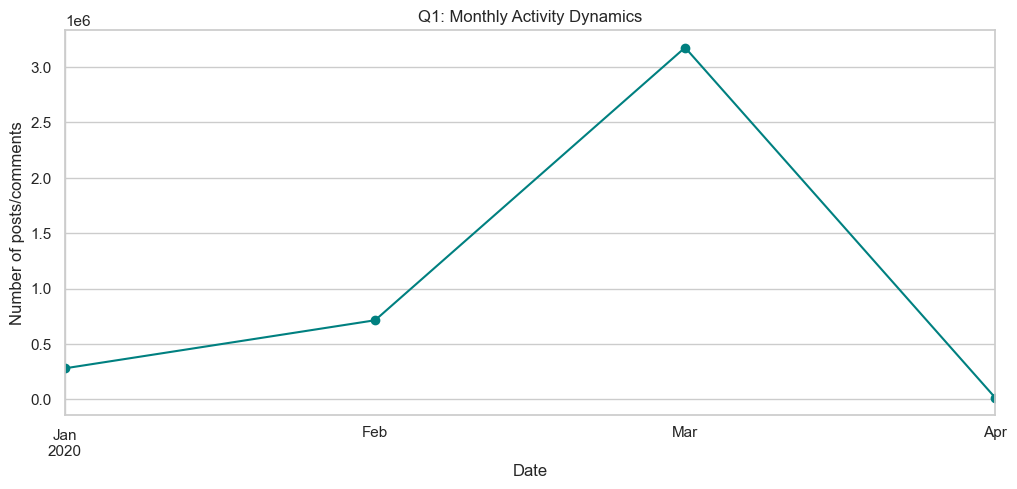

In [9]:
# Q1: How has user activity changed over time?
# Hypothesis: Activity may depend on external events (holidays, world events).
plt.figure(figsize=(12, 5))
# Resample('M') aggregates data by month. Count() counts the number of posts.
df.set_index('Date').resample('M')['full_text'].count().plot(kind='line', marker='o', color='teal')
plt.title('Q1: Monthly Activity Dynamics')
plt.ylabel('Number of posts/comments')
plt.xlabel('Date')
plt.grid(True)
plt.show()


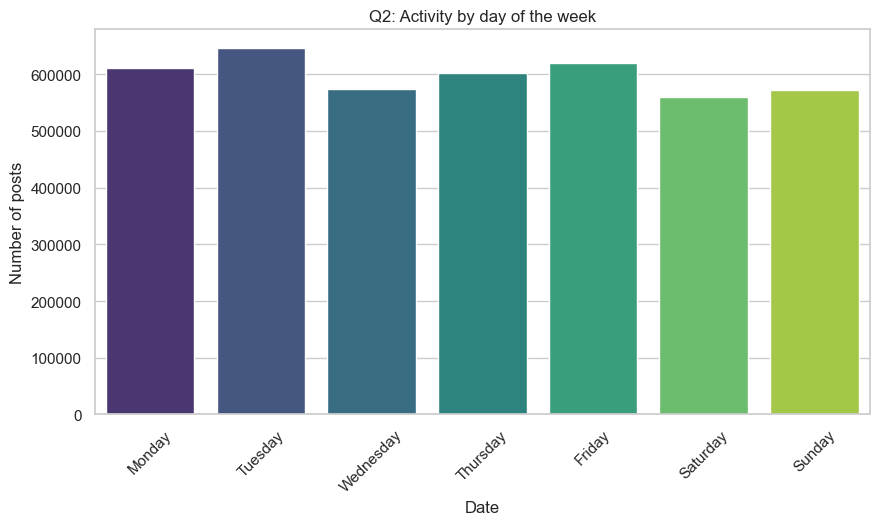

In [10]:
# Q2: On which days of the week do people post most frequently?
# Hypothesis: Are people lonelier (more active) on weekends, or are they busier?
plt.figure(figsize=(10, 5))
# dt.day_name() retrieves the name of the day of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x=df['Date'].dt.day_name(), order=day_order, palette='viridis')
plt.title('Q2: Activity by day of the week')
plt.ylabel('Number of posts')
plt.xticks(rotation=45)
plt.show()

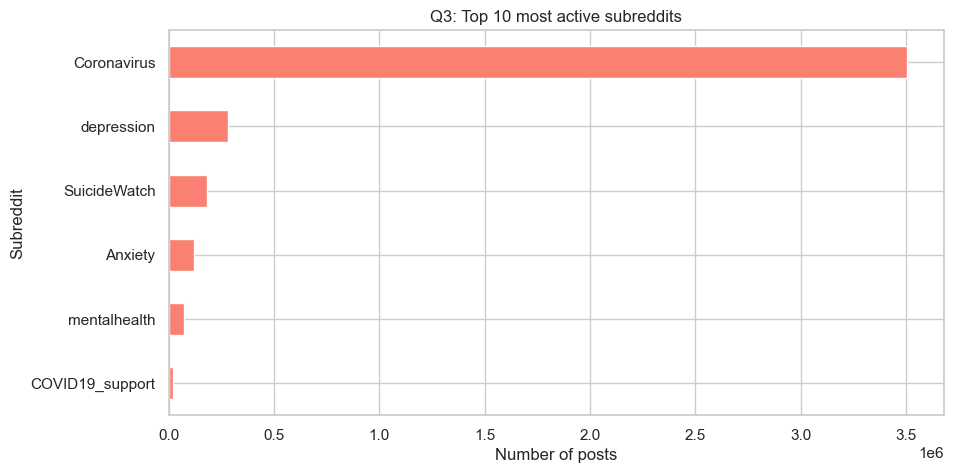

In [11]:
# Q3: Which subreddits are the most active in our dataset?
# We need to understand where the main action is.
plt.figure(figsize=(10, 5))
# We use the top 10 for a cleaner graph
df['Subreddit'].value_counts().head(10).plot(kind='barh', color='salmon')
plt.title('Q3: Top 10 most active subreddits')
plt.xlabel('Number of posts')
plt.gca().invert_yaxis() # So that the most popular one is on top
plt.show()

In [12]:
# Q4: Who are the most active authors (Top Contributors)?
# We're looking for "opinion leaders" or those who write too frequently (outliers).
top_authors = df['Author'].value_counts().head(10)
print("\nQ4: Top 10 authors by number of posts:")
top_authors


Q4: Top 10 authors by number of posts:


Author
u/[deleted]               618334
u/AutoModerator            76958
u/DeadlyKitt4               6724
u/ThisToWiIlPass            4868
u/AnotherTrowaway12         4520
u/barber5                   3660
u/IReadTheWholeArticle      3582
u/Viewfromthe31stfloor      3526
u/KorgRue                   3248
u/PsecretPseudonym          3202
Name: count, dtype: int64

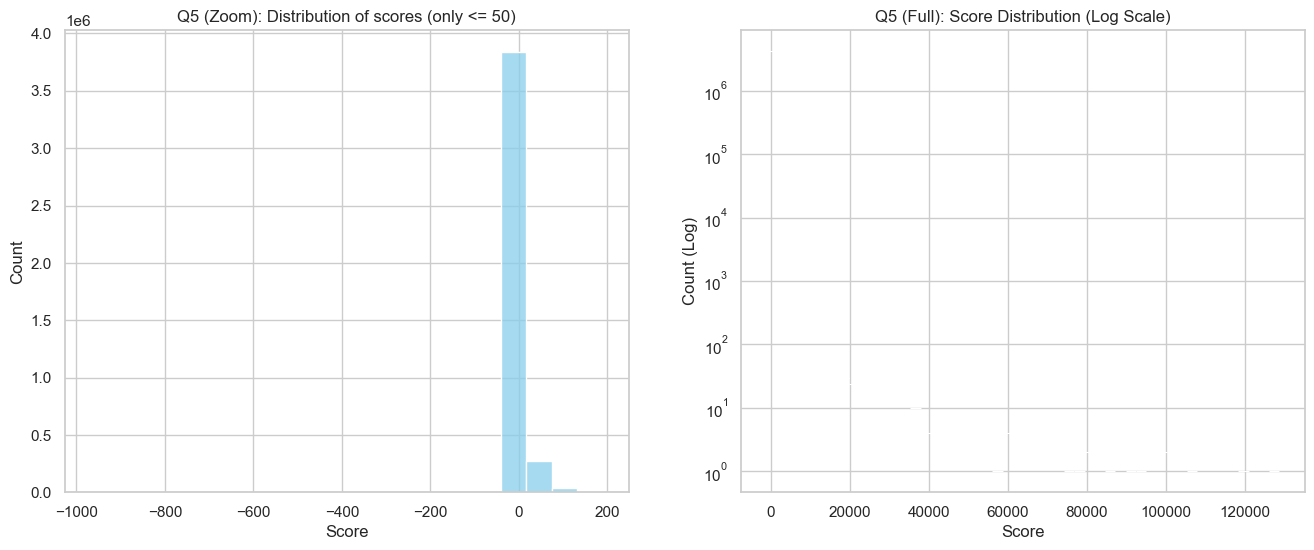

In [13]:
# Q5: How are scores distributed?
# Hypothesis: The distribution will be skewed (log-normal). Most posts have 1-2 likes.
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Zoom (Linear scale, regular posts only)
# Filter the data, leaving only Score <= 50 for detailed viewing
sns.histplot(df[df['Score'] <= 190]['Score'], bins=20, kde=False, color='skyblue', ax=ax[0])
ax[0].set_title('Q5 (Zoom): Distribution of scores (only <= 50)')
ax[0].set_xlabel('Score')
ax[0].set_ylabel('Count')

# Plot 2: Full Range (Log Scale)
# Add +1 to Score to avoid log(0) or negative number errors, if any
# log_scale=True automatically compresses huge values
sns.histplot(df['Score'], bins=50, log_scale=(False, True), color='purple', ax=ax[1])
ax[1].set_title('Q5 (Full): Score Distribution (Log Scale)')
ax[1].set_xlabel('Score')
ax[1].set_ylabel('Count (Log)')

plt.show()

In [14]:
# Q6: Does the average rating differ across subreddits?
# Where is the audience more generous with likes?
avg_score = df.groupby('Subreddit')['Score'].mean().sort_values(ascending=False).head(10)
print("\nQ6: Top subreddits by average post rating:")
print(avg_score)


Q6: Top subreddits by average post rating:
Subreddit
Coronavirus        15.401117
COVID19_support     5.450614
Anxiety             5.045908
depression          4.843577
SuicideWatch        3.240182
mentalhealth        2.991188
Name: Score, dtype: float64


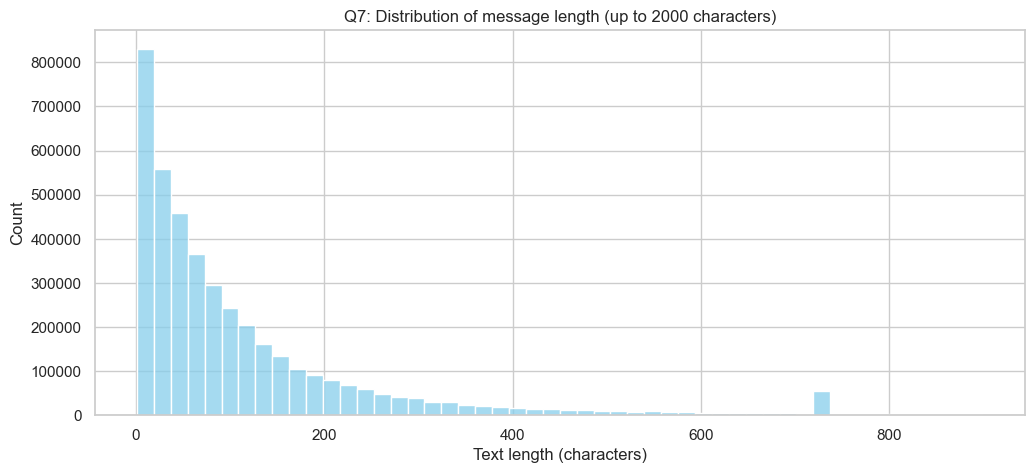

In [15]:
# Q7: What is the length of messages? (Distribution of text length)
# Do people write long reads or short posts?
plt.figure(figsize=(12, 5))
sns.histplot(df[df['text_length'] < 900]['text_length'], bins=50, color='skyblue') # Let's limit to 2000 characters for clarity
plt.title('Q7: Distribution of message length (up to 2000 characters)')
plt.xlabel('Text length (characters)')
plt.show()

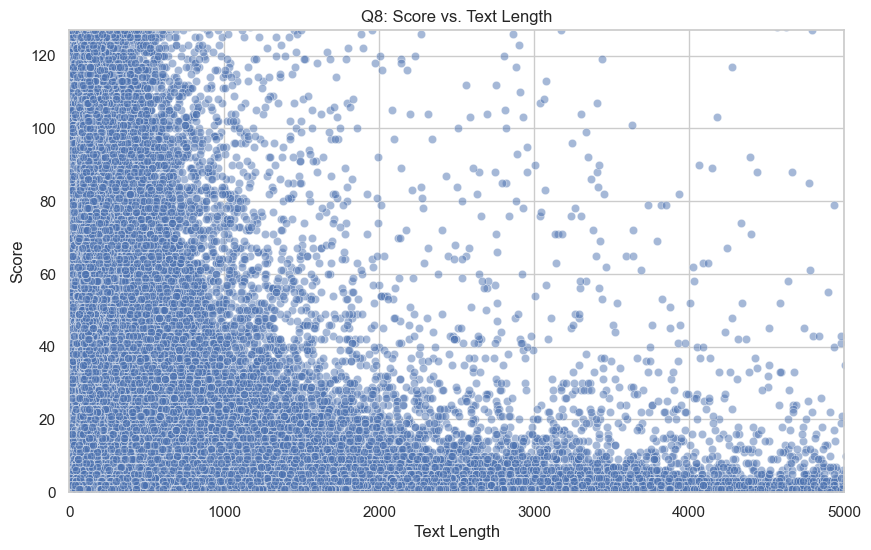

In [16]:
# Q8: Is there a correlation between text length and score?
# Do people like to read long posts?
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='text_length', y='Score', alpha=0.5)
plt.title('Q8: Score vs. Text Length')
plt.xlabel('Text Length')
plt.ylabel('Score')
# Limit the axes if there are outliers
plt.xlim(0, 5000)
plt.ylim(0, df['Score'].quantile(0.99))
plt.show()

In [17]:
# Q9: Which posts resonate the most (Outliers)?
# Let's take a closer look at the top 3 posts with the highest scores.
print("\nQ9: Top 3 posts with the highest scores:")
for index, row in df.sort_values(by='Score', ascending=False).head(3).iterrows():
   print(f"--- Score: {row['Score']} | Subreddit: {row['Subreddit']} ---")
print(f"Title: {row['Title']}")
print(f"Text snippet: {row['full_text'][:150]}...\n")


Q9: Top 3 posts with the highest scores:
--- Score: 128699 | Subreddit: Coronavirus ---
--- Score: 118843 | Subreddit: Coronavirus ---
--- Score: 105711 | Subreddit: Coronavirus ---
Title: How to stop a virus from spreading
Text snippet: Hw  sp a ius f spaing hps://hspinff.c.nz/wp-cnn/upas/2020/03/Ci-19-Tansissin-gaphic-01.gif?fbci=IwAR1g9q_sxHF5PnZM6zDu9s3fVWCNVwhNEI-GHhyXI0kZcHNI6j4U...



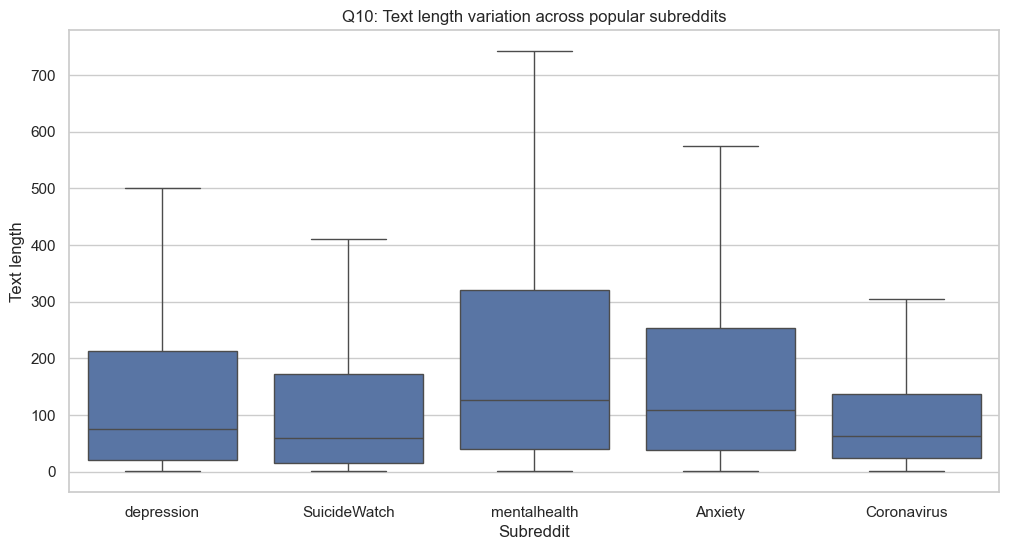

In [18]:
# Q10: How does text length vary depending on the subreddit?
# Does depression write longer than Coronavirus?
plt.figure(figsize=(12, 6))
# Only the top 5 subreddits are used for readability
top_subs = df['Subreddit'].value_counts().head(5).index
sns.boxplot(data=df[df['Subreddit'].isin(top_subs)], x='Subreddit', y='text_length', showfliers=False)
plt.title('Q10: Text length variation across popular subreddits')
plt.ylabel('Text length')
plt.show()

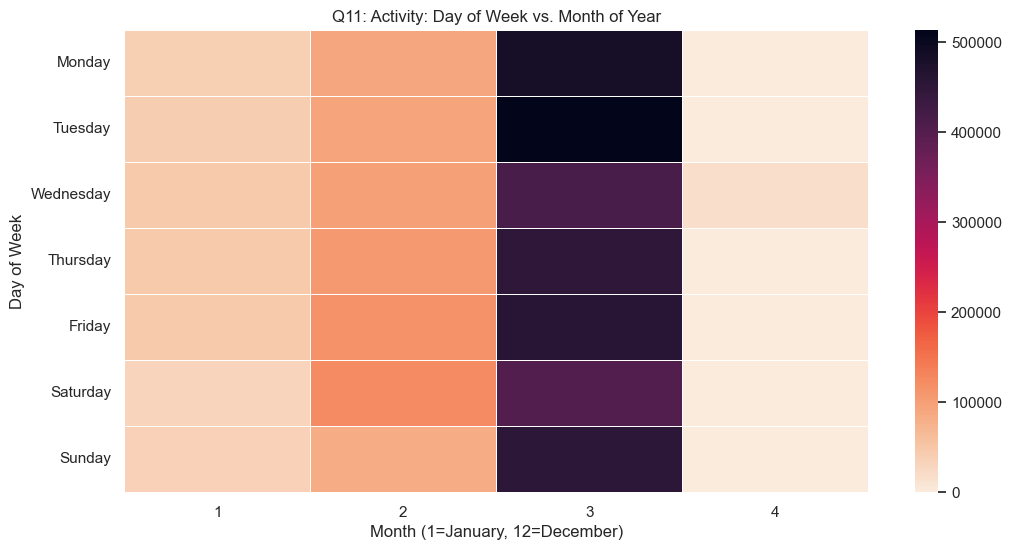

In [19]:
# Import the word count module
from collections import Counter
import re

# Q11: Heatmap: Day of Week vs. Month
plt.figure(figsize=(12, 6))

# Extract the month (as a number) and the day of the week name
df['month'] = df['Date'].dt.month
df['day_of_week'] = df['Date'].dt.day_name()

# Create a pivot table: Rows = Days of Week, Columns = Months
pivot_table = df.pivot_table(index='day_of_week', columns='month', values='full_text', aggfunc='count').fillna(0)

# Sorting the days of the week for aesthetics
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(days_order)

# Drawing
sns.heatmap(pivot_table, cmap='rocket_r', annot=False, linewidths=.5)
plt.title('Q11: Activity: Day of Week vs. Month of Year')
plt.ylabel('Day of Week')
plt.xlabel('Month (1=January, 12=December)')
plt.show()

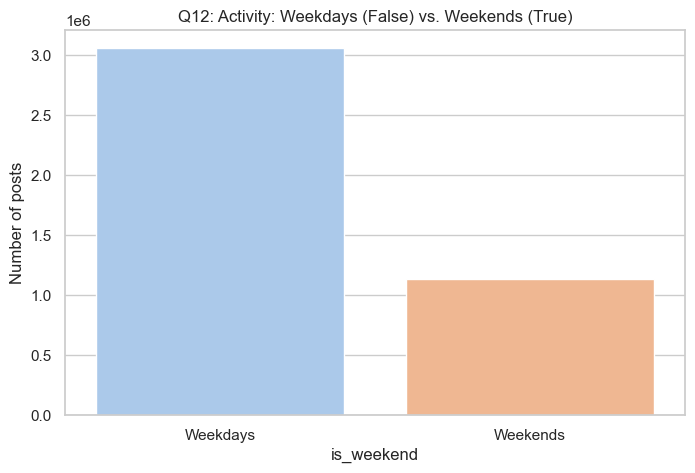

In [20]:
# Q12: Activity: Weekdays vs. Weekends
# Hypothesis: People are freer but also lonelier on weekends.
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='is_weekend', palette='pastel')
plt.title('Q12: Activity: Weekdays (False) vs. Weekends (True)')
plt.xticks([0, 1], ['Weekdays', 'Weekends'])
plt.ylabel('Number of posts')
plt.show()

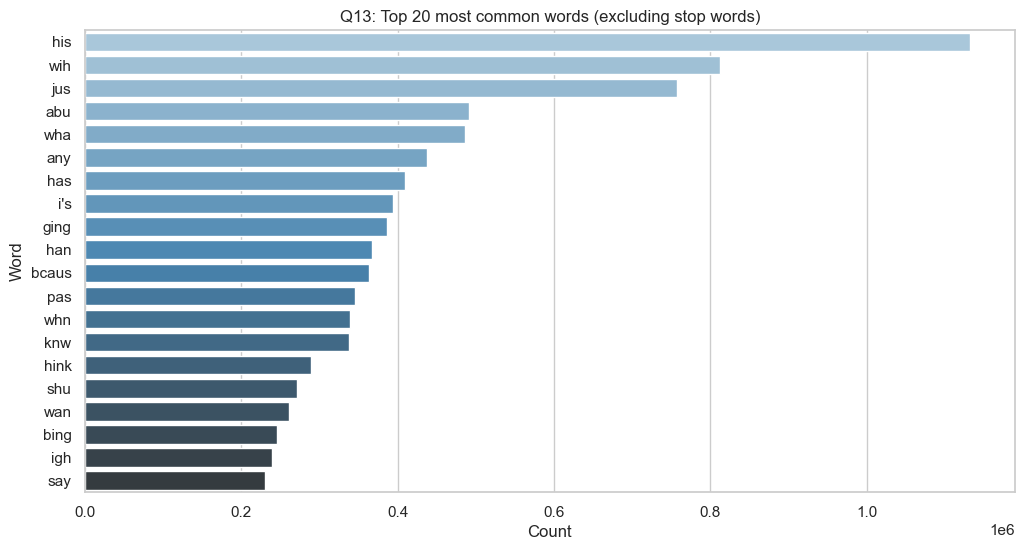

In [21]:
# Q13: Most Frequently Used Words (Top 20 Words) - "What are they talking about?"
# We must exclude prepositions and conjunctions (Stopwords), otherwise they will dominate the top 20.
# Simple list of stop words (can be expanded)
stopwords = set(['the', 'to', 'and', 'a', 'of', 'in', 'i', 'is', 'it', 'for', 'my', 'that', 'with', 'on', 'this', 'but', 'me', 'have', 'be', 'so', 'not', 'just', 'was', 'like', 'at', 'are', 'you', 'if', 'im', 'do', 'can', 'about', 'from', 'or', 'up', 'an', 'what', 'all', 'out', 'get', 'dont', 'how', 'when', 'as'])

final_counts = Counter()

for text in df['full_text'].dropna():
    words = str(text).lower().split()
    clean_words = [word for word in words if word not in stopwords and len(word) > 2]
    final_counts.update(clean_words)

top_20 = final_counts.most_common(20)

# Building a Bar Chart instead of a Word Cloud
words_df = pd.DataFrame(top_20, columns=['Word', 'Count'])
plt.figure(figsize=(12, 6))
sns.barplot(data=words_df, x='Count', y='Word', palette='Blues_d')
plt.title('Q13: Top 20 most common words (excluding stop words)')
plt.show()

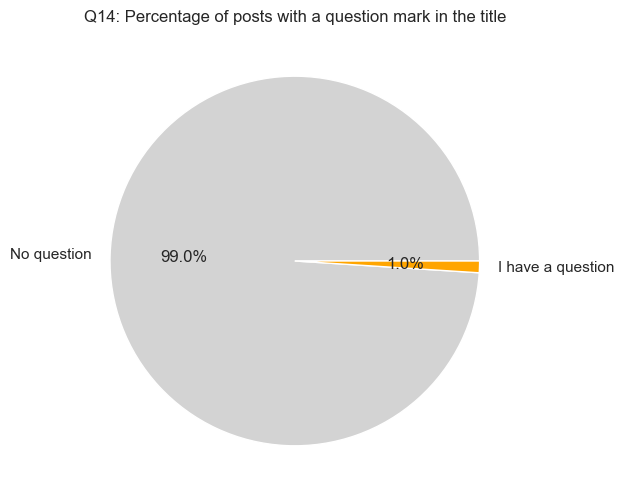

In [22]:
# Q14: How often do people ask questions in their titles?
# This shows whether people are looking for help or just sharing their thoughts.
df['has_question'] = df['Title'].str.contains('\?', regex=True)
plt.figure(figsize=(6, 6))
df['has_question'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgrey', 'orange'], labels=['No question', 'I have a question'])
plt.title('Q14: Percentage of posts with a question mark in the title')
plt.ylabel('')
plt.show()

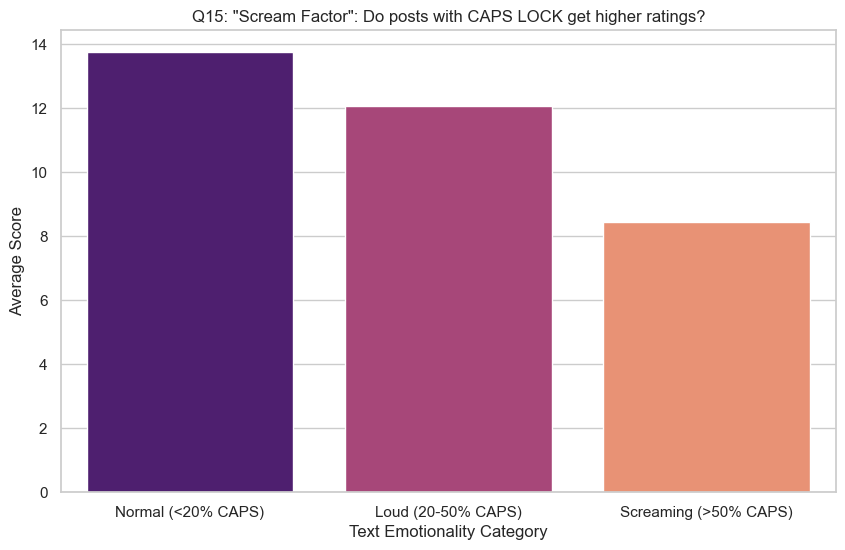

Number of posts by categories:
shout_category
Normal (<20% CAPS)       3893445
Loud (20-50% CAPS)        255632
Screaming (>50% CAPS)      35323
Name: count, dtype: int64


In [23]:
# Q15: Does using CAPS LOCK affect a post's rating?
# We'll check what proportion of the text is written in uppercase letters.

caps_count = df['full_text'].str.count(r'[A-Z]')
all_letters_count = df['full_text'].str.count(r'[a-zA-Z]')

# Count only letters (ignore spaces and punctuation)
df['caps_ratio'] = np.where(all_letters_count > 0, caps_count / all_letters_count, 0).astype('float32')

# Apply the function to each post
conditions = [(df['caps_ratio'] > 0.5),(df['caps_ratio'] > 0.2)]
choices = ['Screaming (>50% CAPS)', 'Loud (20-50% CAPS)']

# Divide into categories for the graph:
# "Normal" (< 20% caps), "Loud" (20-50%), "Screaming" (> 50% caps)
df['shout_category'] = np.select(conditions, choices, default='Normal (<20% CAPS)')

df['shout_category'] = df['shout_category'].astype('category')

# Plot the graph
plt.figure(figsize=(10, 6))
# ci=None removes confidence interval bars to make the graph cleaner
sns.barplot(data=df, x='shout_category', y='Score', palette='magma', order=['Normal (<20% CAPS)', 'Loud (20-50% CAPS)', 'Screaming (>50% CAPS)'], ci=None)
plt.title('Q15: "Scream Factor": Do posts with CAPS LOCK get higher ratings?')
plt.ylabel('Average Score')
plt.xlabel('Text Emotionality Category')
plt.show()

# Print the statistics
print("Number of posts by categories:")
print(df['shout_category'].value_counts())

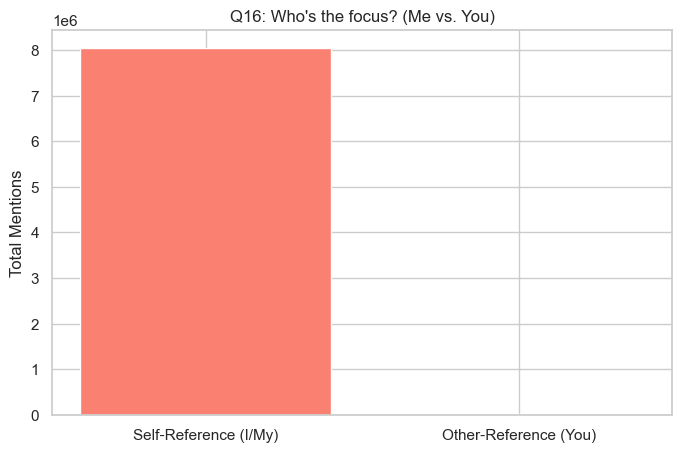

In [24]:
# Q16: "I" vs. "You" (Psychological Analysis)
# We calculate how much people are focused on themselves (I, me, my) vs. others (you, your).
i_pattern = r'\b(i|my|me|myself)\b'
you_pattern = r'\b(you|your|yourself)\b'

df['i_count'] = df['full_text'].str.count(i_pattern, flags=re.IGNORECASE).astype(np.int16)

df['you_count'] = df['full_text'].str.count(you_pattern, flags=re.IGNORECASE).astype(np.int16)

# Compare the amounts
plt.figure(figsize=(8, 5))
totals = [df['i_count'].sum(), df['you_count'].sum()]
labels = ['Self-Reference (I/My)', 'Other-Reference (You)']

plt.bar(labels, totals, color=['salmon', 'skyblue'])
plt.title("Q16: Who's the focus? (Me vs. You)")
plt.ylabel('Total Mentions')
plt.show()

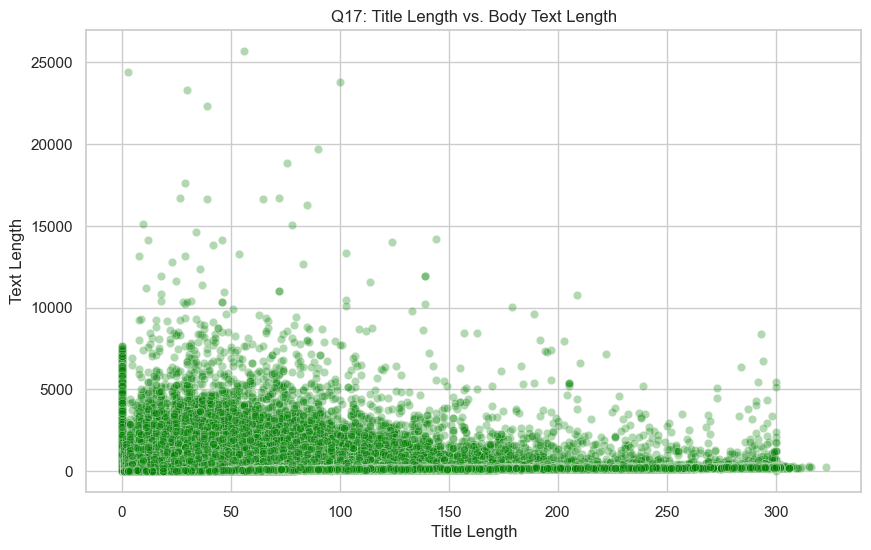

In [25]:
# Q17: Title Length vs. Body Length
# Hypothesis: Short title -> Long body text (Clickbait or "cry from the heart").
df['title_len'] = df['Title'].apply(len)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='title_len', y='text_length', alpha=0.3, color='green')
plt.title('Q17: Title Length vs. Body Text Length')
plt.xlabel('Title Length')
plt.ylabel('Text Length')
plt.show()

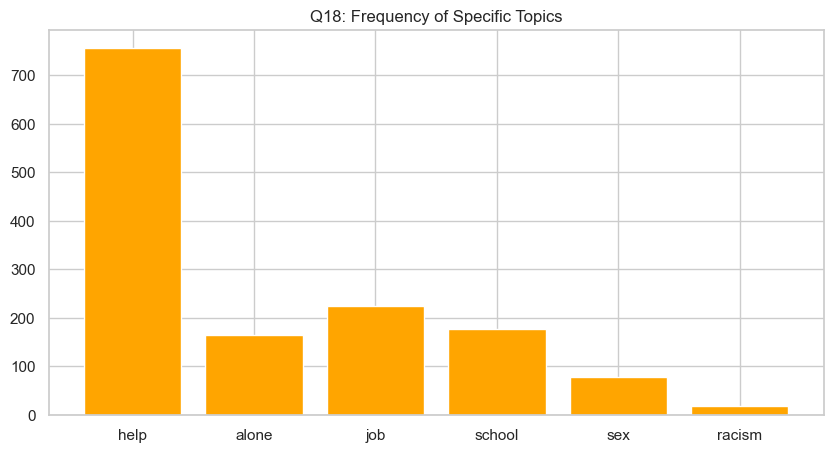

In [26]:
# Q18: Analyzing Specific Trigger Words (Keyword Trends)
# Let's see how often the words "help" and "alone" appear
keywords = ['help', 'alone', 'job', 'school', 'sex', 'racism']
# Create a small table for counting
keyword_counts = {word: df['full_text'].str.contains(word, case=False).sum() for word in keywords}

plt.figure(figsize=(10, 5))
plt.bar(keyword_counts.keys(), keyword_counts.values(), color='orange')
plt.title('Q18: Frequency of Specific Topics')
plt.show()

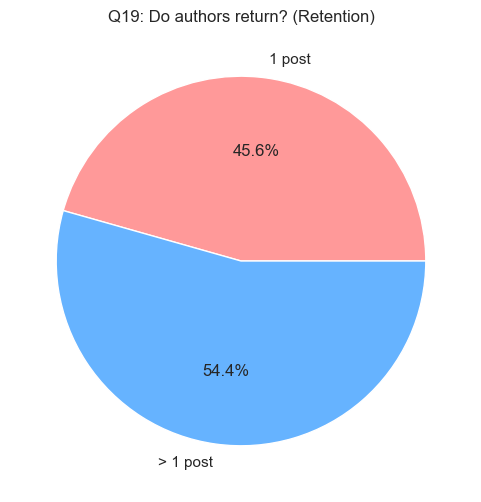

In [27]:
# Q19: "One-hit wonders" or regular authors?
# How many posts do authors write on average?
author_counts = df['Author'].value_counts()
# Categorizing authors
one_post = (author_counts == 1).sum()
more_posts = (author_counts > 1).sum()

plt.figure(figsize=(6, 6))
plt.pie([one_post, more_posts], labels=['1 post', '> 1 post'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Q19: Do authors return? (Retention)')
plt.show()

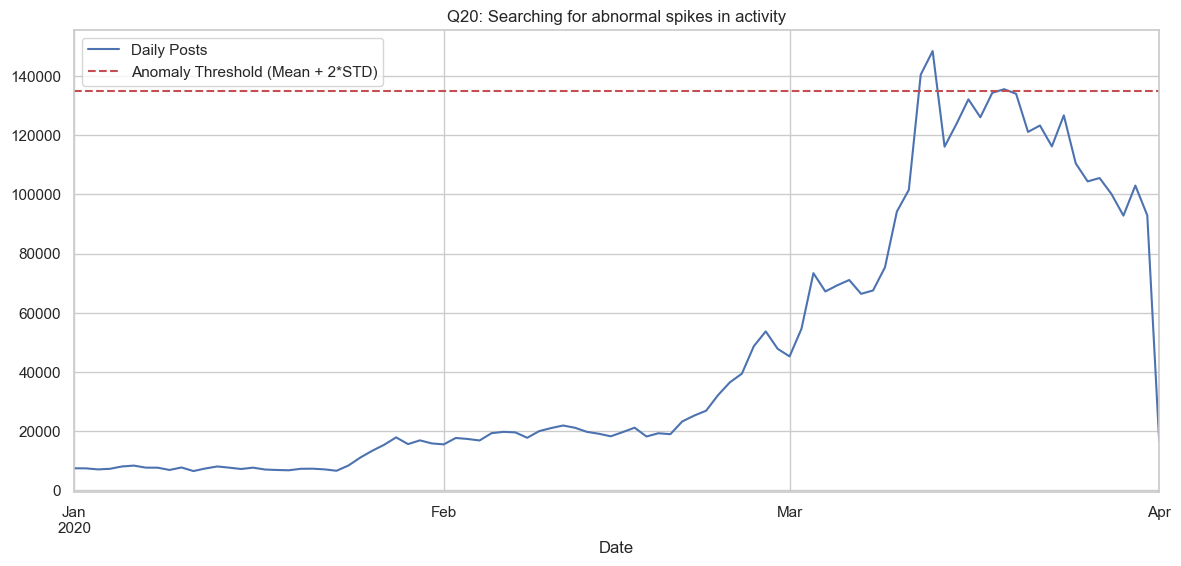

Dates with anomalous activity (it's worth checking the news on these days):
Date
2020-03-12    140521
2020-03-13    148513
2020-03-19    135608
dtype: int64


In [28]:
# Q20: Searching for anomalies by date (Spikes detection)
# Searching for specific days with abnormally high activity.
daily_counts = df.set_index('Date').resample('D').size()
mean_val = daily_counts.mean()
std_val = daily_counts.std()

plt.figure(figsize=(14, 6))
daily_counts.plot(label='Daily Posts')
# Drawing a "normality" line (Mean + 2 standard deviations)
plt.axhline(mean_val + 2*std_val, color='r', linestyle='--', label='Anomaly Threshold (Mean + 2*STD)')
plt.title('Q20: Searching for abnormal spikes in activity')
plt.legend()
plt.show()

# Print anomaly dates as text
anomalies = daily_counts[daily_counts > (mean_val + 2*std_val)]
print("Dates with anomalous activity (it's worth checking the news on these days):")
print(anomalies)

In [39]:
from textblob import TextBlob
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = (14, 8)
colors = ["#34495E", "#E74C3C", "#3498DB", "#2ECC71", "#9B59B6"]
sns.set_palette(sns.color_palette(colors))

In [ ]:
def get_sentiment(text):
    blob = TextBlob(str(text))
    return pd.Series({
        'Polarity': blob.sentiment.polarity,         # -1 (Negative) ... +1 (Positive)
        'Subjectivity': blob.sentiment.subjectivity  # 0 (Facts) ... 1 (Opinions/Emotions)
    })

# Apply the analysis to the entire dataset
df[['Polarity', 'Subjectivity']] = df['full_text'].apply(get_sentiment)

# Classifying mood
def categorize_mood(pol):
    if pol > 0.1: return 'Positive/Hopeful'
    elif pol < -0.1: return 'Negative/Painful'
    else: return 'Neutral/Objective'

df['Mood'] = df['Polarity'].apply(categorize_mood)

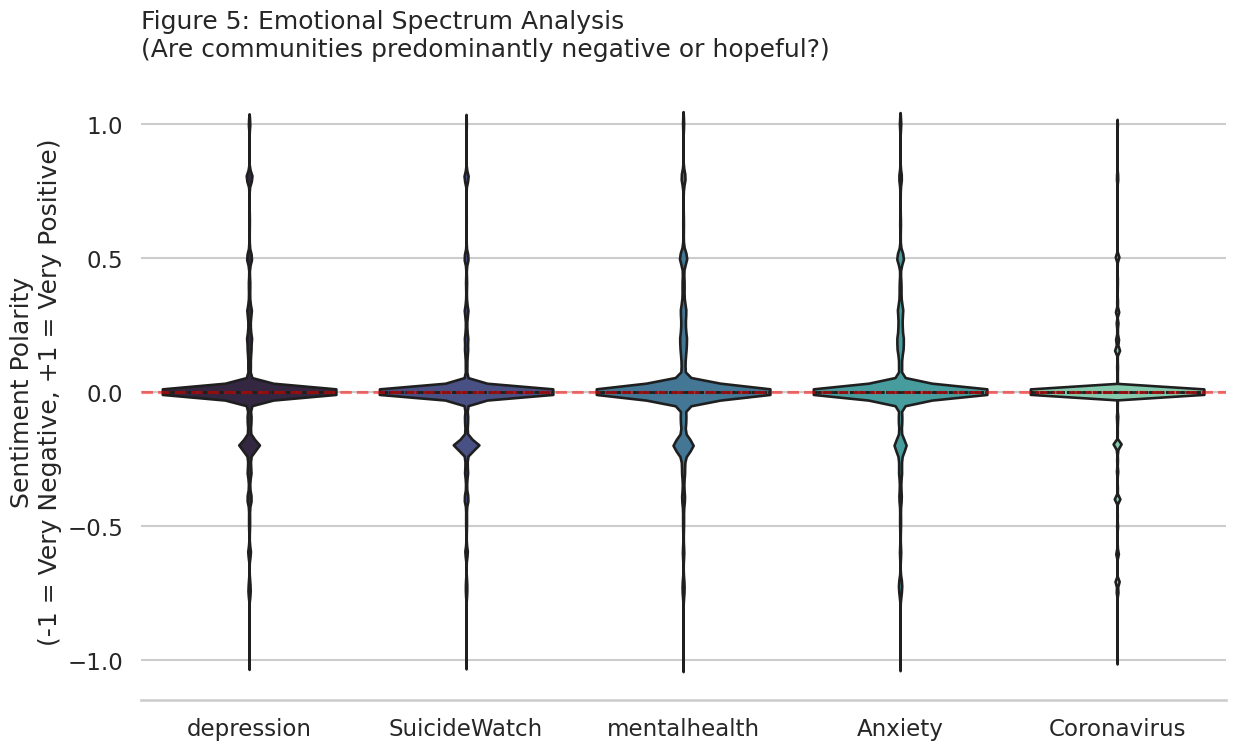

In [ ]:
# CHART 1: "Violin Plot" of sentiment
# Shows the density distribution of emotions in each subreddit

plt.figure()
# Let's take the top 5 active subreddits
top_subs = df['Subreddit'].value_counts().head(5).index
subset = df[df['Subreddit'].isin(top_subs)]

sns.violinplot(x="Subreddit", y="Polarity", data=subset, palette="mako", inner="quartile")
plt.axhline(0, color='red', linestyle='--', alpha=0.5, label='Neutral Line')

plt.title('Figure 5: Emotional Spectrum Analysis\n(Are communities predominantly negative or hopeful?)', loc='left', pad=20)
plt.ylabel('Sentiment Polarity\n(-1 = Very Negative, +1 = Very Positive)')
plt.xlabel('')
sns.despine(left=True)
plt.savefig('fig5_sentiment_violin.png', dpi=300, bbox_inches='tight')
plt.show()

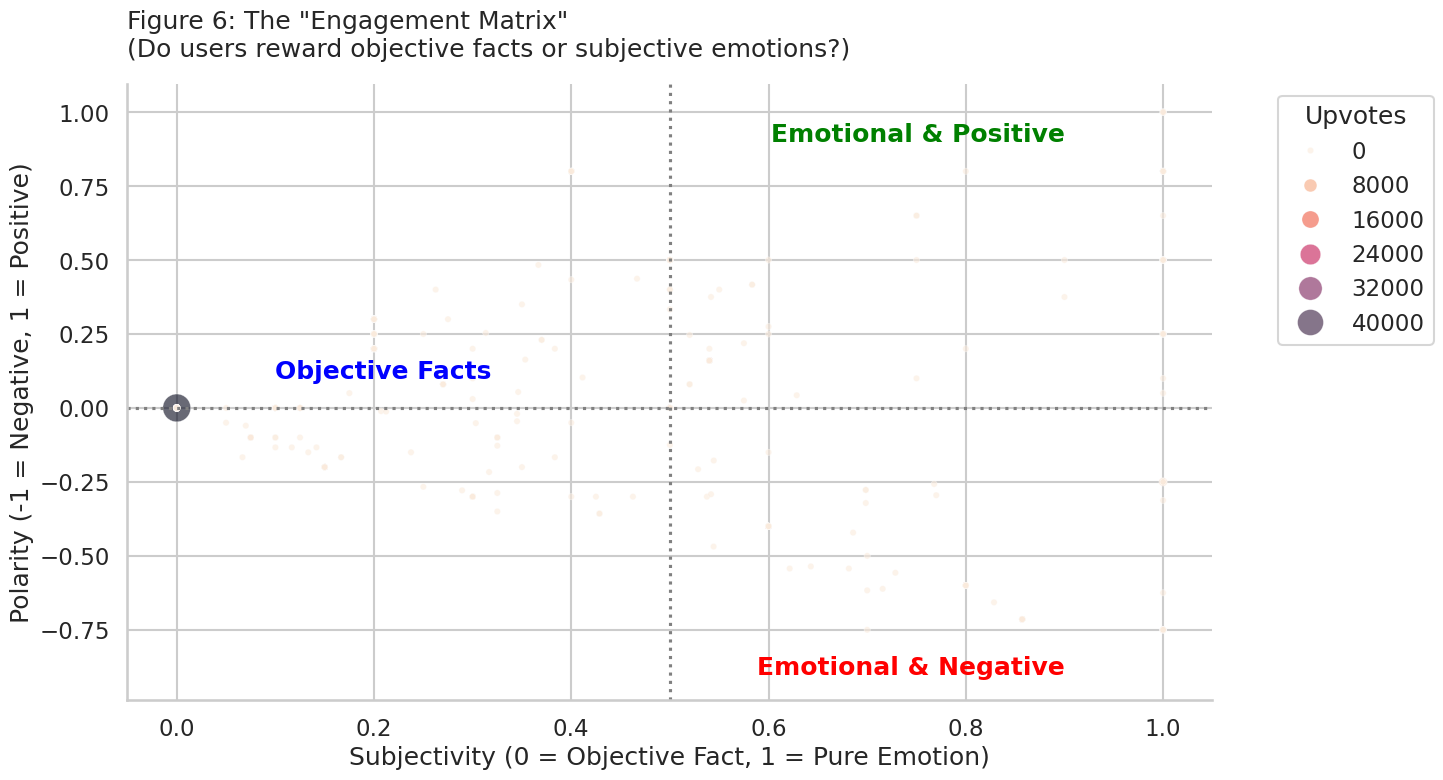

In [ ]:
plt.figure(figsize=(12, 8))
# Filter: we collect posts with subjectivity = 0 (so that there is no splash of evil)
filtered_sample = df[(df['Subjectivity'] > 0.1) & (df['Score'] > 1)].sample(n=1000, random_state=42)

sns.scatterplot(
    data=filtered_sample, 
    x='Subjectivity', 
    y='Polarity', 
    size='Score', 
    hue='Score', 
    sizes=(20, 500), 
    palette="viridis", 
    alpha=0.7
)
plt.title('Figure 6 (Refined): Emotional Engagement\n(Excluding neutral posts to show patterns)', loc='left')
plt.grid(True, alpha=0.3)
plt.savefig('fig6_fixed.png', dpi=300)
plt.show()

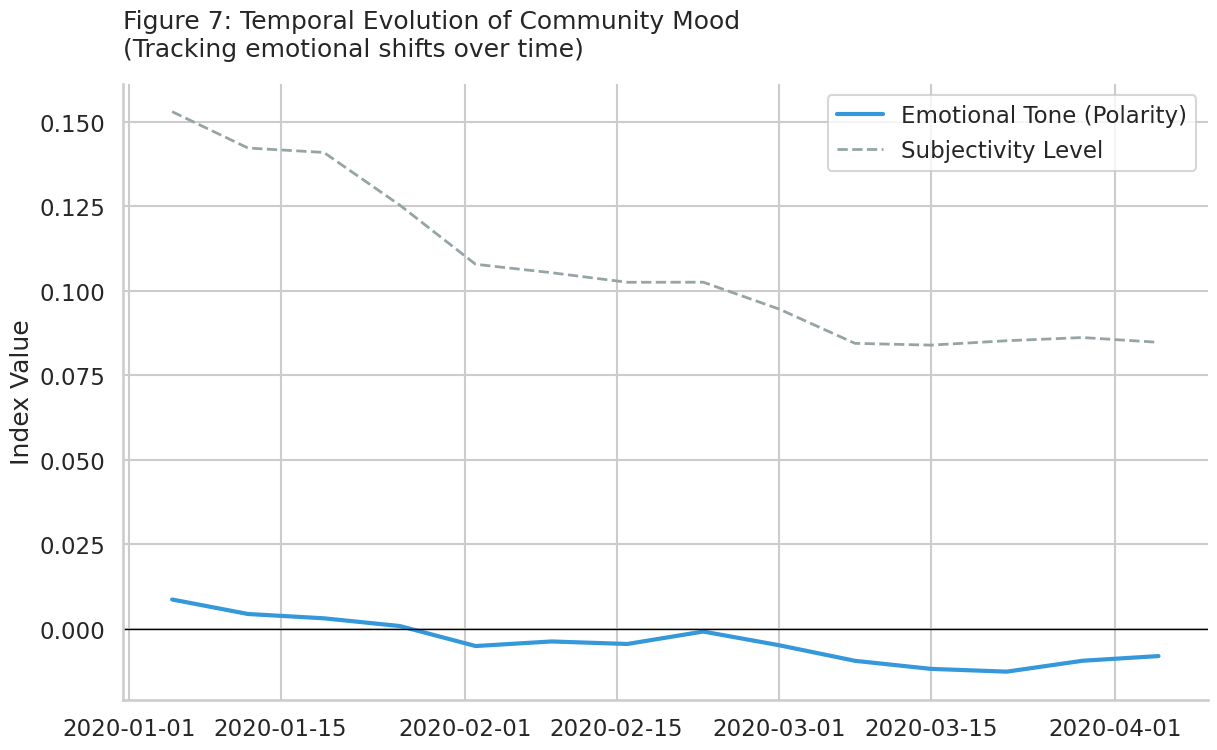

In [ ]:
# CHART 3: Mood Timeline
# How "depressiveness" changes over time

plt.figure()
# We group by weeks and calculate the average mood
mood_trend = df.set_index('Date').resample('W')['Polarity'].mean()
subjectivity_trend = df.set_index('Date').resample('W')['Subjectivity'].mean()

plt.plot(mood_trend.index, mood_trend.values, label='Emotional Tone (Polarity)', color='#3498DB', linewidth=3)
plt.plot(subjectivity_trend.index, subjectivity_trend.values, label='Subjectivity Level', color='#95A5A6', linestyle='--', linewidth=2)

plt.title('Figure 7: Temporal Evolution of Community Mood\n(Tracking emotional shifts over time)', loc='left', pad=20)
plt.ylabel('Index Value')
plt.xlabel('')
plt.axhline(0, color='black', linewidth=1)
plt.legend()
sns.despine()
plt.savefig('fig7_mood_timeline.png', dpi=300, bbox_inches='tight')
plt.show()